C:\Users\sumit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- Loading Data ---
Loading 12892 images at 128x128...

--- Building Advanced Model ---

--- Starting Training (30 Epochs) ---
Epoch 1/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 287s 857ms/step - loss: 249487.4531 - val_loss: 490734.7188
Epoch 2/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 258s 797ms/step - loss: 215134.5469 - val_loss: 204460.1875
Epoch 3/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 257s 796ms/step - loss: 212363.4844 - val_loss: 215528.6250
Epoch 4/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 251s 778ms/step - loss: 209633.5469 - val_loss: 276687.5000
Epoch 5/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 243s 752ms/step - loss: 205164.1719 - val_loss: 223171.1562
Epoch 6/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 241s 747ms/step - loss: 199577.3906 - val_loss: 375071.1875
Epoch 7/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 241s 746ms/step - loss: 190577.4844 - val_loss: 287362.7812
Epoch 8/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 218s 607ms/step - loss: 182961.7031 - val_loss: 299366.8750
Epoch 9/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 218s 675ms/step - loss: 174201.3

Model saved as house_price_model_v2.h5


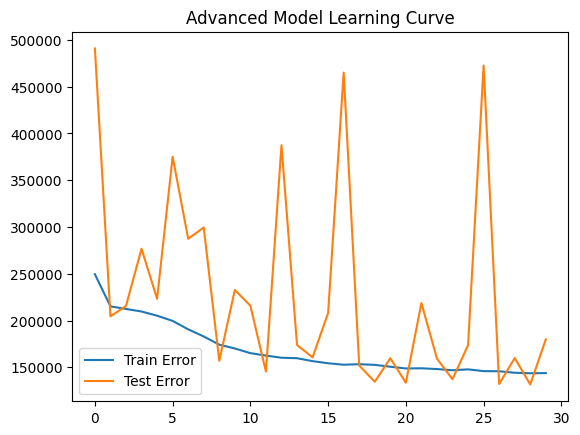

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout, BatchNormalization, RandomFlip

# ================= CONFIGURATION =================
DATA_FILE = "cleaned_dataset.csv"
IMAGE_DIR = "data/house_images"
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
# =================================================

def load_data():
    print("--- Loading Data ---")
    if not os.path.exists(DATA_FILE):
        print(f"Error: {DATA_FILE} not found!")
        return None, None, None, None

    df = pd.read_csv(DATA_FILE)
    
    print(f"Loading {len(df)} images at {IMG_SIZE}x{IMG_SIZE}...")
    images = []
    ids_to_drop = []
    
    for index, row in df.iterrows():
        try:
            img_path = os.path.join(IMAGE_DIR, f"image_{row['id']}.jpg")
            img = Image.open(img_path).convert('RGB')
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = np.array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            ids_to_drop.append(index)
    
    if ids_to_drop:
        df = df.drop(ids_to_drop)
        print(f"Dropped {len(ids_to_drop)} bad images.")
    
    X_images = np.array(images)
    
    feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long']
    available_cols = [c for c in feature_cols if c in df.columns]
    
    X_stats = df[available_cols].values
    y_price = df['price'].values
    
    scaler = MinMaxScaler()
    X_stats = scaler.fit_transform(X_stats)
    
    return X_images, X_stats, y_price, scaler

def build_advanced_model(img_shape, stats_shape):
    # --- IMAGE BRANCH ---
    img_input = Input(shape=img_shape)
    x = RandomFlip("horizontal")(img_input)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    
    # --- STATS BRANCH ---
    stats_input = Input(shape=(stats_shape,))
    y = Dense(64, activation='relu')(stats_input)
    y = Dropout(0.3)(y)
    y = Dense(32, activation='relu')(y)
    
    # --- MERGE ---
    combined = Concatenate()([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.4)(z)
    final_output = Dense(1, activation='linear')(z)
    
    model = Model(inputs=[img_input, stats_input], outputs=final_output)
    model.compile(optimizer='adam', loss='mae')
    return model

def main():
    X_img, X_stats, y, scaler = load_data()
    
    if X_img is None:
        return

    X_img_train, X_img_test, X_stats_train, X_stats_test, y_train, y_test = train_test_split(
        X_img, X_stats, y, test_size=0.2, random_state=42
    )
    
    print("\n--- Building Advanced Model ---")
    model = build_advanced_model(X_img.shape[1:], X_stats.shape[1])
    
    print("\n--- Starting Training (30 Epochs) ---")
    history = model.fit(
        [X_img_train, X_stats_train], y_train,
        validation_data=([X_img_test, X_stats_test], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    print("\n--- Evaluation ---")
    loss = model.evaluate([X_img_test, X_stats_test], y_test)
    print("Original Model Error: ~$225,000")
    print(f"New Model Error:      ${loss:,.2f}")
    
    model.save('house_price_model_v2.h5')
    print("Model saved as house_price_model_v2.h5")
    
    plt.plot(history.history['loss'], label='Train Error')
    plt.plot(history.history['val_loss'], label='Test Error')
    plt.title('Advanced Model Learning Curve')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()